## Data Cleaning

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import numpy as np

#Load file
dataframe = pd.read_csv("data.csv", delimiter=";")

print(f"We got {len(dataframe)} rows and {len(dataframe.columns)} columns")

#Extract Data
features = pd.DataFrame()

dataframe.loc[dataframe['CRP    '].str.startswith('<'),'CRP    ']=0
dataframe=dataframe.iloc[:,[2,4,6,8,10,12,14,16,18,21,24,26,28,30,33,35,37,41,42,43]]
#Treat string data as NaN
pd.options.mode.chained_assignment = None

for col in dataframe:
    dataframe[col]=pd.to_numeric(dataframe[col], errors='coerce') 

#Replace NaN by mean value
imp = SimpleImputer(missing_values=pd.NA, strategy='median')
dataframe=pd.DataFrame(imp.fit_transform(dataframe))
features['GB'] = 1 / (1 + np.exp(-(dataframe.iloc[:,0] - 10)))
features['GR'] = 1 / (1 + np.exp(-(dataframe.iloc[:,1] - 10)))
features['Epi'] = 1 / (1 + np.exp(-(dataframe.iloc[:,2] - 5)))
features['Nepi'] = 1 / (1 + np.exp(-(dataframe.iloc[:,3] - 5)))
features['Levure'] = 1 / (1 + np.exp(-(dataframe.iloc[:,4] - 10)))
features['Bacterie'] = 1 / (1 + np.exp(-(dataframe.iloc[:,5] - 148)))
features['CylH'] = 1 / (1 + np.exp(-(dataframe.iloc[:,6] - 5)))
features['CylP'] = 1 / (1 + np.exp(-(dataframe.iloc[:,7] - 3)))
features['Crystaux'] = 1 / (1 + np.exp(-(dataframe.iloc[:,8] - 3)))
features['ERY'] = dataframe.iloc[:,9]
features['LEU'] = dataframe.iloc[:,10]
features['NIT'] = 1 / (1 + np.exp(-(dataframe.iloc[:,11] - 60.2)))
features['KET'] = dataframe.iloc[:,12]
features['GLU'] = dataframe.iloc[:,13]
features['PRO'] = dataframe.iloc[:,14]
features['Prote'] = dataframe.iloc[:,15]
features['PH'] = dataframe.iloc[:,16]
features['SG'] = dataframe.iloc[:,17]
features['CRP'] = dataframe.iloc[:,18]
features['target'] = dataframe.iloc[:,19]
scaledFeatures = pd.DataFrame(preprocessing.scale(features),columns = features.columns)
features

We got 181 rows and 52 columns


,GB,GR,Epi,Nepi,Levure,Bacterie,CylH,CylP,Crystaux,ERY,LEU,NIT,KET,GLU,PRO,Prote,PH,SG,CRP,target
0,0.000045,0.000045,0.006693,0.006693,0.000045,5.301719e-65,0.006693,0.047426,0.047426,69.18,69.59,9.984220e-01,51.85,70.12,64.38,485.0,68.07,1.012,0.00,0.0
1,1.000000,0.997100,0.057324,0.006693,0.000045,1.298876e-47,0.006693,0.047426,0.047426,10.15,35.06,9.901462e-01,54.41,69.66,60.91,93.0,67.59,1.022,22.07,0.0
2,1.000000,1.000000,0.127862,0.990806,0.000045,4.862241e-47,0.006693,0.047426,0.047426,6.50,39.10,1.561819e-10,52.29,72.14,57.17,120.0,9.31,1.015,40.85,1.0
3,0.000045,0.003684,0.037688,0.006693,0.000045,3.574210e-44,0.006693,0.047426,0.047426,71.70,62.51,9.941182e-01,55.07,72.65,65.90,21.0,33.27,1.004,1.18,0.0
4,1.000000,0.049266,0.948826,0.037688,0.000070,4.202369e-37,0.006693,0.047426,0.047426,44.57,49.38,9.948315e-01,48.03,68.66,59.06,185.0,68.37,1.022,22.07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,1.000000,1.000000,0.006693,0.006693,0.000045,1.000000e+00,0.006693,0.999992,0.047426,4.94,26.58,9.560602e-01,51.95,67.17,50.65,318.0,63.65,1.019,18.92,0.0
177,1.000000,1.000000,0.006693,0.011096,0.000126,1.000000e+00,0.006693,0.999992,1.000000,7.47,46.19,9.493097e-01,51.97,71.11,54.92,663.0,68.01,1.016,118.00,0.0
178,1.000000,1.000000,0.999999,0.006693,0.000045,1.000000e+00,0.006693,1.000000,0.047426,7.77,27.30,9.950332e-01,54.51,68.75,41.22,670.0,37.18,1.018,16.99,1.0
179,1.000000,1.000000,0.006693,0.006693,0.000045,1.000000e+00,0.006693,1.000000,1.000000,5.05,58.77,9.908969e-01,47.05,68.93,58.73,230.0,12.04,1.013,125.77,0.0


## Feature selection technique

Problem space has >10 dimensions, we fall into https://en.wikipedia.org/wiki/Curse_of_dimensionality. 

<Axes: >

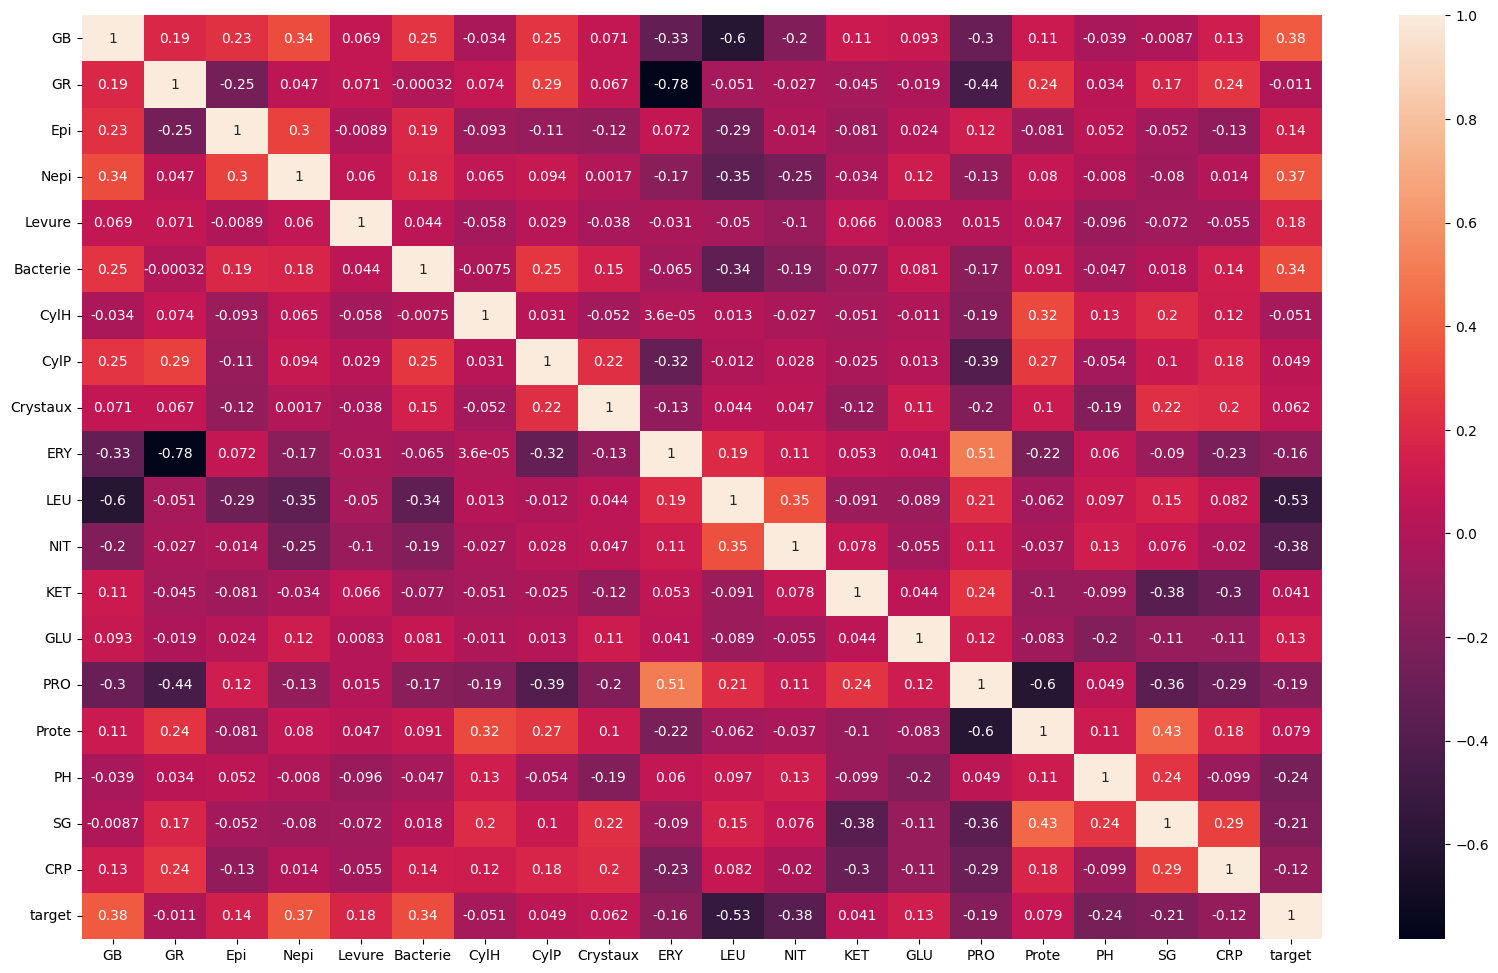

In [2]:
#Let's try to see the matrix of correlation
import seaborn as sns
		     
plt.figure(figsize=(20,12))
sns.heatmap(features.corr(),annot = True)

In [3]:
from sklearn.feature_selection import VarianceThreshold

v_Treshold = VarianceThreshold(threshold=0.01)
v_Treshold.fit(features)
v_Treshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True])

In [4]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import LinearSVC

ffs = SequentialFeatureSelector(LinearSVC(max_iter=10000), n_features_to_select=8)
ffs.fit(scaledFeatures.iloc[:, 0:19].values,features.iloc[:,19].values.ravel())
ffs.get_support(indices=True)
reducedFeatures = scaledFeatures.iloc[:, ffs.get_support(indices=True)]

In [5]:
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.naive_bayes  import GaussianNB

# ffs = SequentialFeatureSelector(GaussianNB(), n_features_to_select=8)
# ffs.fit(features.iloc[:, 0:19].values,features.iloc[:,19].values.ravel())
# ffs.get_support(indices=True)
# reducedFeatures = features.iloc[:, ffs.get_support(indices=True)]

In [6]:
# ExhaustiveFeatureSelector, but take an eternity
# from mlxtend.feature_selection import ExhaustiveFeatureSelector
# from sklearn.ensemble import RandomForestClassifier
# X_train, X_test, Y_train,Y_test = train_test_split(scaledFeatures, target, test_size=0.2)
# efs=ExhaustiveFeatureSelector(RandomForestClassifier(),min_features=2, max_features=4,scoring = 'roc_auc',print_progress=True)
# efs = efs.fit(scaledFeatures, target.values.ravel())
# print('Best accuracy score: %.2f' % efs.best_score_)
# print('Best subset (indices):', efs.best_idx_)
# print('Best subset (corresponding names):', efs.best_feature_names_)

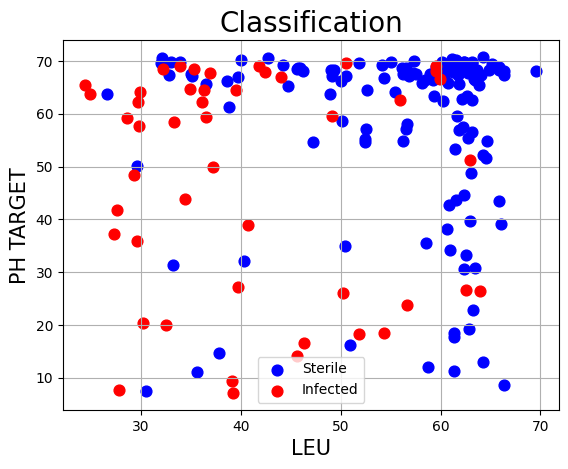

In [7]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes  import GaussianNB

ffs = SequentialFeatureSelector(GaussianNB(), n_features_to_select=2)
ffs.fit(features.iloc[:, 0:19].values,features.iloc[:,19].values.ravel())
ffs.get_support(indices=True)
reducedFeaturesForPlot = features.iloc[:, [10,16]]
reducedFeaturesForPlot['target'] = features.iloc[:,19]
#plot the first 2 principals components
fig = plt.figure()
ax = fig.add_subplot() 
ax.set_xlabel('LEU', fontsize = 15)
ax.set_ylabel('PH TARGET', fontsize = 15)
ax.set_title('Classification', fontsize = 20)

cond = reducedFeaturesForPlot['target'] == 0

subset_a = reducedFeaturesForPlot[cond]
subset_b = reducedFeaturesForPlot[~cond]
plt.scatter(subset_a.iloc[:,0], subset_a.iloc[:,1], s=60, c='b', label='Sterile')
plt.scatter(subset_b.iloc[:,0], subset_b.iloc[:,1], s=60, c='r', label='Infected') 
ax.legend()
ax.grid()

## Model fitting

In [8]:
#Lets try to classify anyway, using https://medium.com/thrive-in-ai/classification-algorithms-in-python-5f58a7a27b88
#https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.svm import LinearSVC

X_train, X_test, Y_train,Y_test = train_test_split(reducedFeatures, features.iloc[:,19], test_size=0.2)
lr_clf = LinearSVC(max_iter=10000).fit(X_train,Y_train.values.ravel())
lr_clf.score(X_test,Y_test)

0.8648648648648649

In [10]:
from sklearn.naive_bayes  import GaussianNB

X_train, X_test, Y_train,Y_test = train_test_split(reducedFeatures, features.iloc[:,19], test_size=0.2)
lr_clf = GaussianNB().fit(X_train,Y_train.values.ravel())
lr_clf.score(X_test,Y_test)

0.8108108108108109

In [11]:
# from sklearn import tree
# X_train, X_test, Y_train,Y_test = train_test_split(features.iloc[:,0:19], features.iloc[:,19], test_size=0.2)
# lr_clf = tree.DecisionTreeClassifier().fit(preprocessing.scale(X_train),Y_train.values.ravel())
# lr_clf.score(X_test,Y_test)
# plt.figure(figsize=(18,18))
# tree.plot_tree(lr_clf, feature_names=features.iloc[:,0:19].columns, fontsize=10)

## PCA for fun

In [12]:
#Let's find the most relevant dimension using PCA

#We first need to normalize the data

pca = PCA()

principalComponents = pca.fit_transform(scaledFeatures)

print (f"percentage of precision with the number of components :\n {pca.explained_variance_ratio_.cumsum()}")

#relationship from data to component
#print(pd.DataFrame(pca.components_,columns=x.columns))
principalDf = pd.DataFrame(data = principalComponents)

finalDf = pd.concat([principalDf, features.iloc[:,19]], axis = 1)

percentage of precision with the number of components :
 [0.17956022 0.32250562 0.40455787 0.4760193  0.53513088 0.59028708
 0.64079888 0.68741062 0.72895564 0.76934525 0.80643752 0.84141207
 0.87294997 0.90014073 0.92679989 0.94673024 0.96512398 0.97929411
 0.99177856 1.        ]


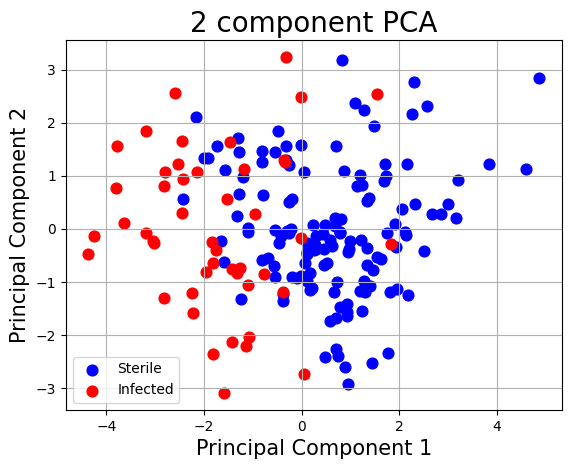

In [13]:
#plot the first 2 principals components
fig = plt.figure()
ax = fig.add_subplot() 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

cond = finalDf.iloc[:,-1:] == 0
cond = cond.squeeze()
subset_a = finalDf[cond.squeeze()]
subset_b = finalDf[~cond]
plt.scatter(subset_a.iloc[:,1], subset_a.iloc[:,2], s=60, c='b', label='Sterile')
plt.scatter(subset_b.iloc[:,1], subset_b.iloc[:,2], s=60, c='r', label='Infected') 
ax.legend()
ax.grid()